<a href="https://colab.research.google.com/github/udayman/WhitesonATLASwork/blob/main/AspirationDecorrelatedToy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Standard Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
!pip install --upgrade tables

     |████████████████████████████████| 4.3 MB 9.3 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


# Load Data

In [ ]:
files = np.load("/content/gdrive/MyDrive/MC_Prod_v12/Nov18/W_high_level.npz")
test = files["test"]
train = files["train"]
val = files["val"]

In [ ]:
np.shape(test)

(850000, 12)

In [ ]:
np.shape(train)

(360000, 12)

In [ ]:
np.shape(val)

(410000, 12)

In [ ]:
((test[:,-1] == 1).sum(), (test[:,-1] == 0).sum(), (test[:,-1] == 1).sum()/(test[:,-1] == 0).sum())

(770000, 80000, 9.625)

In [ ]:
((train[:,-1] == 1).sum(), (train[:,-1] == 0).sum(), (train[:,-1] == 1).sum()/(train[:,-1] == 0).sum())

(110000, 250000, 0.44)

In [ ]:
((val[:,-1] == 1).sum(), (val[:,-1] == 0).sum(), (val[:,-1] == 1).sum()/(val[:,-1] == 0).sum()) 
#comment out weights

(330000, 80000, 4.125)

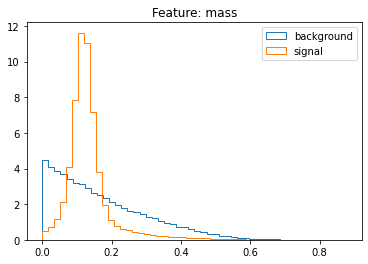

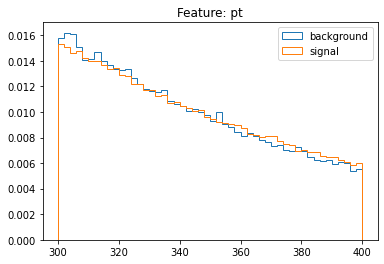

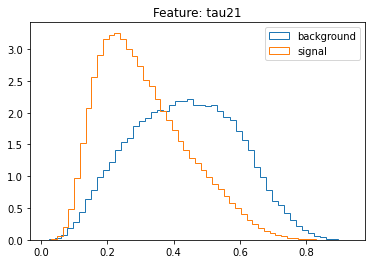

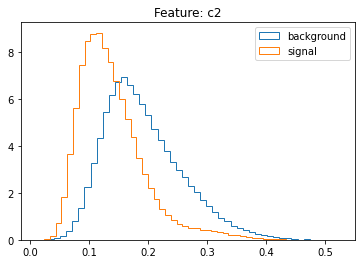

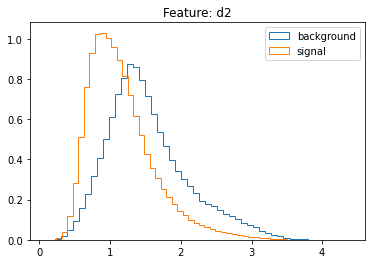

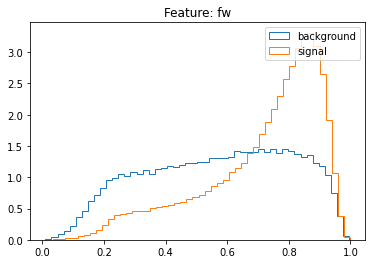

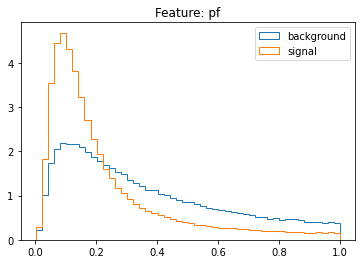

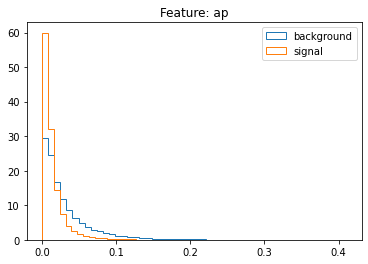

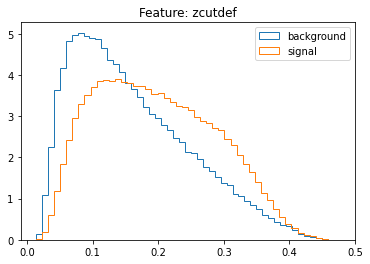

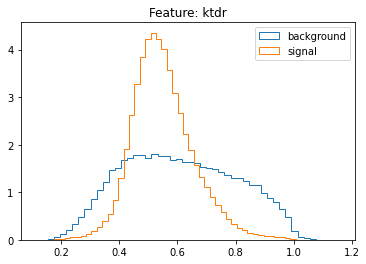

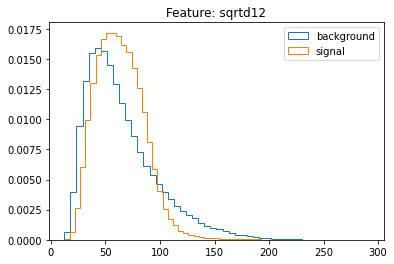

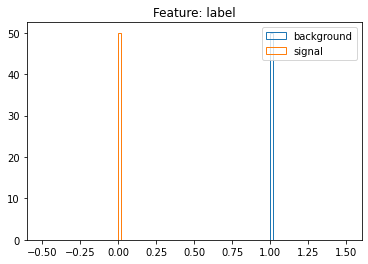

In [ ]:
names = ['mass','pt','tau21', 'c2', 'd2','fw', 'pf','ap','zcutdef','ktdr','sqrtd12','label']
for i, name in enumerate(names):
  plt.title("Feature: " + name)
  plt.hist(train[train[:,-1] == 1,i], histtype="step", bins = 50, density = 1, label="background")
  plt.hist(train[train[:,-1] == 0,i], histtype="step", bins = 50, density = 1, label="signal")
  plt.legend()
  plt.show()

In [ ]:
#load signal, backgound data
#vbf_events = pd.read_hdf("/content/gdrive/MyDrive/MC_Prod_v12/Nov18/vbf_events.hdf", "vbf") #do hdf5!!
#ggf_events = pd.read_hdf("/content/gdrive/MyDrive/MC_Prod_v12/Nov18/ggF_events.hdf", "ggF")
#qq_events = pd.read_hdf("/content/gdrive/MyDrive/MC_Prod_v12/Nov18/qq_all_events.hdf", "qq_all")

In [ ]:
#vbf_events["class"] = 1
#ggf_events["class"] = 2 # need to reweight ggF better! set to 0 afterwards
#qq_events["class"] 

In [ ]:
#vbf_events.columns


In [ ]:
#class_weights = qq_events.weight_couplings.sum(), vbf_events.weight_couplings.sum(), ggf_events.weight_couplings.sum()
#print(class_weights)
#max(class_weights)

In [ ]:
#data = pd.concat([vbf_events, ggf_events, qq_events])
#data = pd.concat([vbf_events, ggf_events])
#print data.isnull().values.any()
#data.describe()

#data = data.sample(frac=1).reset_index(drop=True) #shuffle the events
#target = data["class"]
#mass = data["m4l_fsr"]
#weights = data["weight_couplings"]
#del data["class"]
#del data["m4l_fsr"]
#del data["weight_couplings"]

In [ ]:
'''
data.columns
del data["dijet_invmass"]
del data["jet_pt[0]"]
del data["jet_pt[1]"]
'''

'\ndata.columns\ndel data["dijet_invmass"]\ndel data["jet_pt[0]"]\ndel data["jet_pt[1]"]\n'

In [ ]:
np.random.shuffle(train)
np.random.shuffle(test)

X_train = train[:, :-1]
y_train = train[:, -1]
X_test = test[:, :-1]
y_test = test[:, -1]

In [ ]:
weights_train = np.ones_like(y_train)
weights_test = np.ones_like(y_test)

In [ ]:
mass_train = train[:,0]
mass_train = mass_train*250 + 50

mass_test = test[:,0]
mass_test = mass_test*250 + 50



mass_train = np.log(mass_train)
mass_test = np.log(mass_test)
mass_max, mass_min = max(mass_train.max(), mass_test.max()), min(mass_train.min(), mass_test.min())
mass_train = (mass_train - mass_min)/(mass_max - mass_min) #!!! save max, min values to file

mass_test = np.log(mass_test)
mass_test = (mass_test - mass_min)/(mass_max - mass_min) #!!! save max, min values to file
#mass.describe()
#plt.hist(mass)
#plt.show()

In [ ]:
from sklearn.utils import class_weight
class_weights_train = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced', np.unique(y_train), 
                y_train))) 
class_weights_test = dict(zip(np.unique(y_test), class_weight.compute_class_weight('balanced', np.unique(y_test), 
                y_test))) 

In [ ]:
#first only for background make reweighting through (label 0)source (entire source dataset) vs (label 1)target(only on mass, signal = source signal, background = target signal) (background train mass match background target mass)
# find if output is correlated
# multiply original weights by background reweighting where applicable
#training swont train standard way

### Split Train-Test

### Reweight Events
Training: 1000x everything, fraction 1/3 VBF 1/3 ggF 1/3 qq ~~0.5 VBF, 0.25 ggF, 0.25 qq~~

Testing: Back to original VBF, ggF, qq sum of weights

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_size = 0.75 # 0.1 # !!!
#X_train, X_test, y_train, y_test, mass_train, mass_test, weights_train, weights_test = \
    #train_test_split(data.values, target.values, mass.values, weights.values, train_size=train_size)
#reset index for dataseries, not needed for ndarray (X_train, X_test)
'''
y_train, y_test, mass_train, mass_test, weights_train, weights_test = \
 y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    mass_train.reset_index(drop=True), mass_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)
'''

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#class_weights_test = weights_test[y_test == 0].sum(), weights_test[y_test == 1].sum(), weights_test[y_test == 2].sum()
#scale_up = 1000.
'''
for i in range(3):
    weights_train[y_train == i] *= scale_up*max(class_weights)/ class_weights[i]
    weights_test[y_test == i] *= class_weights[i]/class_weights_test[i]
'''


'\nfor i in range(3):\n    weights_train[y_train == i] *= scale_up*max(class_weights)/ class_weights[i]\n    weights_test[y_test == i] *= class_weights[i]/class_weights_test[i]\n'

In [ ]:
#weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum(), weights_train[y_train == 2].sum()

In [ ]:
#weights_test[y_test == 0].sum(), weights_test[y_test == 1].sum(), weights_test[y_test == 2].sum()

### Make ggF background

In [ ]:
#y_train[y_train == 2] = 0
#y_test[y_test == 2] = 0

# Classical NN

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score

inputs = Input(shape=(X_train.shape[1],))
Dx = Dense(32, activation="relu")(inputs)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
DNN = Model(inputs=[inputs], outputs=[Dx])
DNN.compile(loss="binary_crossentropy", optimizer="adam")

def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    from collections import Counter
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority) / count for cls, count in counter.items()}

In [ ]:
class_weights = class_weights_train

In [ ]:
DNN.fit(X_train, y_train, class_weight=class_weights, epochs =20)
#D.fit(X_train, y_train, sample_weight=weights_train, nb_epoch=1) #short for testing purposes
#D.fit(X_train, y_train, nb_epoch=10) #unweighted training
#D.fit(X_train, y_train, nb_epoch=10, class_weight=get_class_weights(y_train)) #Only interclass weights

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
11250/11250 [==============================] - 20s 2ms/step - loss: 0.4282
Epoch 2/20
11250/11250 [==============================] - 19s 2ms/step - loss: 0.4158
Epoch 3/20
11250/11250 [==============================] - 21s 2ms/step - loss: 0.4121
Epoch 4/20
11250/11250 [==============================] - 20s 2ms/step - loss: 0.4099
Epoch 5/20
11250/11250 [==============================] - 20s 2ms/step - loss: 0.4080
Epoch 6/20
11250/11250 [==============================] - 19s 2ms/step - loss: 0.4066
Epoch 7/20
11250/11250 [==============================] - 19s 2ms/step - loss: 0.4054
Epoch 8/20
11250/11250 [==============================] - 18s 2ms/step - loss: 0.4043
Epoch 9/20
11250/11250 [==============================] - 18s 2ms/step - loss: 0.4033
Epoch 10/20
11250/11250 [==============================] - 18s 2ms/step - loss: 0.4029
E

In [ ]:
#len(vbf_events), len(ggf_events), len(qq_events)

In [ ]:
from sklearn.metrics import roc_auc_score
y_pred = DNN.predict(X_test)
y_pred = y_pred.ravel()
#auc_test_nn = roc_auc_score(y_true=y_test, y_score=y_pred, sample_weight=weights_test)
#print auc_test_nn
#roc_auc_score(y_true=y_test, y_score=y_pred)

from sklearn.metrics import roc_curve
lw = 2
fpr_nn,tpr_nn,_ = roc_curve(y_true=y_test, y_score=y_pred, sample_weight=weights_test)
plt.plot(fpr_nn, tpr_nn, color='darkorange',lw=lw, label='NN (AUC = {})'.format(np.round(auc_test_nn,decimals=2)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_pred_train = DNN.predict(X_train).ravel()

In [ ]:
#int_pred_test_sig = [weights_train[(y_train ==1) & (y_pred_train > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
#int_pred_test_bkg = [weights_train[(y_train ==0) & (y_pred_train > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

int_pred_test_sig = [weights_test[(y_test ==0) & (y_pred > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg = [weights_test[(y_test ==1) & (y_pred > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

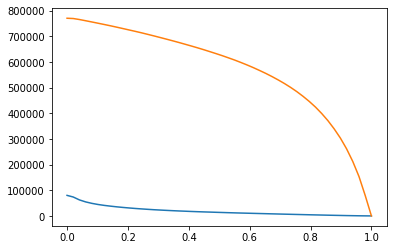

In [ ]:
plt.plot(np.linspace(0,1,num=50),int_pred_test_sig)
plt.plot(np.linspace(0,1,num=50),int_pred_test_bkg)

In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/UtilFunc')

In [ ]:
from util_func import amsasimov
vamsasimov = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig,int_pred_test_bkg)]
significance = max(vamsasimov)
threshold = np.linspace(0,1,num=50)[ np.array(vamsasimov).argmax() ]

In [ ]:
significance, threshold

(89.65444150891518, 0.0)

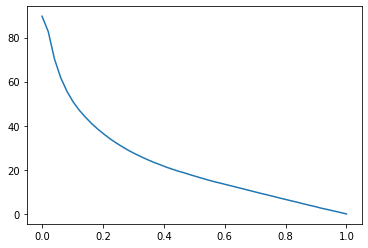

In [ ]:
plt.plot(np.linspace(0,1,num=50),vamsasimov)

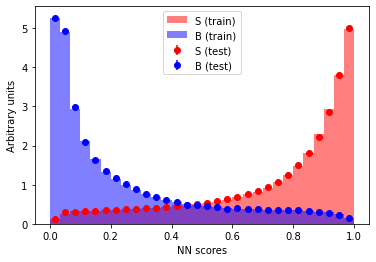

In [ ]:
from util_func import compare_train_test
compare_train_test(y_pred_train, y_train, y_pred, y_test)

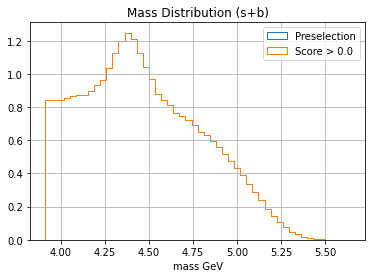

In [ ]:
def getGevMass(mass):
    return np.exp (mass * (mass_max - mass_min) + mass_min)
plt.hist(getGevMass(mass_test), weights=weights_test, bins=50, histtype="step", density=1, label="Preselection")
plt.hist(getGevMass(mass_test[y_pred >= threshold]), weights=weights_test[y_pred >= threshold], bins=50, histtype="step", density=1, label="Score > " + str(threshold))

plt.title("Mass Distribution (s+b)")
#plt.ylim(0, 4)
#plt.xlim(200, 1200)
plt.xlabel("mass GeV")
plt.legend()
plt.grid()
plt.show()

# Aspiration Adversary that looks at mass and real/fake

In [ ]:
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def make_trainable(network, flag):
    network.trainable = flag
    for l in network.layers:
        l.trainable = flag

inputs = Input(shape=(X_train.shape[1],))
inputs_b = Input(shape=(X_train.shape[1],))
inputs_s = Input(shape=(X_train.shape[1],))

with K.name_scope('Classifier'):
    Dx = Dense(32, activation="relu")(inputs)
    Dx = Dense(32, activation="relu")(Dx)
    Dx = Dense(32, activation="relu")(Dx)
    Dx = Dense(1, activation="sigmoid")(Dx)
    D = Model(inputs=[inputs], outputs=[Dx])
#@Doesnt work: loss on only the signal
Rin1 = Input(shape=(1,))
Rin2 = Input(shape=(1,))
Rin = concatenate([Rin1, Rin2 ], axis=-1)
with K.name_scope('Advers'):
    Rx = Dense(32, activation="relu")(Rin)
    Rx = Dense(32, activation="relu")(Rx)
    Rx = Dense(32, activation="relu")(Rx)
    Rx = Dense(1, activation="sigmoid")(Rx)
    R = Model(inputs=[Rin1, Rin2], outputs=[Rx])

inX = Input(shape=(X_train.shape[1],))
inM = Input(shape=(1,))
D_out_for_R = D(inX)
R_out = R([D_out_for_R, inM])
DC = Model(inputs=[inX, inM], outputs=[R_out])

In [ ]:

#from keras.optimizers import SGD
#from keras.losses import mean_squared_error
from tensorflow.keras.losses import binary_crossentropy

lam = 20.0 #10.0 # trade-off #originally 3, increased  #increase 100x

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        #return c * K.binary_crossentropy(y_true, y_pred)
        return c * K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1) #!!! new keras from 2.0.7
    return loss_D

def make_loss_R(c):
    #def loss_R(z_true, z_pred):
    def loss_R(y_true, y_pred):
        #return c * mean_squared_error(z_true, z_pred) ##!!! new keras from 2.0.7
        #return K.mean(y_true * y_pred) 
        return c * binary_crossentropy(y_true, y_pred)
    return loss_R

#opt_D = SGD()
opt_D = "adam"
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)
#D.compile(loss="binary_crossentropy", optimizer=opt_D)
R.compile(loss= [make_loss_R(c=1.0)], optimizer=opt_D)

# Train D such that R loss (its c=-lam) is also minimised, make it invariant to R
#TODO: try grad reversal layer
#opt_DRf = SGD(momentum=0.0)
opt_DRf = "adam"


DRf = Model(inputs=[inputs, Rin2], outputs=[D(inputs), DC([inputs, Rin2])])
# R only on signal (doesn't work as well as trained on both)
#DRf = Model(input=[inputs_b, inputs_s], output=[D(inputs_b),D(inputs_s), R(inputs_s)])
make_trainable(R, False)
make_trainable(D, True)
#DRf.compile(loss=[make_loss_D(c=1.0),make_loss_D(c=1.0), make_loss_R(c=-lam)], optimizer=opt_DRf)
DRf.compile(loss=[make_loss_D(c=1.0), make_loss_R(c=-lam)], optimizer=opt_DRf)
#DRf.compile(loss=["binary_crossentropy", "mean_squared_error"], loss_weights=[1,-lam], optimizer=opt_DRf)

#opt_DfR = SGD(momentum=0.0)
opt_DfR = "adam" #!!!
#opt_DfR = SGD(lr=0.0000001)
DfR = Model(inputs=[Rin1, Rin2], outputs=[R([Rin1, Rin2])])
make_trainable(R, True)
make_trainable(D, False)
#DfR.compile(loss=[make_loss_R(c=1.0)], optimizer=opt_DfR)
DfR.compile(loss=[make_loss_R(c=lam)], optimizer=opt_DfR)
#DfR.compile(loss=["mean_squared_error"], loss_weights=[lam],optimizer=opt_DfR)
#DfR.compile(loss="mean_squared_error",optimizer=opt_DfR)

In [ ]:
y_train = y_train.astype(np.float32)
X_train = X_train.astype(np.float32)

In [ ]:
#DfR.save('/content/gdrive/MyDrive/DecorrelationModels/Aspiration1')
useSavedModel = 0

In [ ]:
#sample_weight calculations
#calculating weights
mask_sample_weight_test = np.copy(y_test)
mask_sample_weight_test[mask_sample_weight_test == 1] = class_weights_test[1]
mask_sample_weight_test[mask_sample_weight_test == 0] = 0

mask_sample_weight_train = np.copy(y_train)
mask_sample_weight_train[mask_sample_weight_train == 1] = class_weights_train[1]
mask_sample_weight_train[mask_sample_weight_train == 0] = 0

sample_weight_test = np.copy(y_test)
sample_weight_test[sample_weight_test == 1] = class_weights_test[1]
sample_weight_test[sample_weight_test == 0] = class_weights_test[0]

#for train calculation
sample_weight1 = np.copy(y_train)

sample_weight1[sample_weight1 == 1] = class_weights[1]
sample_weight1[sample_weight1 == 0] = class_weights[0]

sample_weight2 = np.copy(y_train)

sample_weight2[sample_weight2 == 1] = class_weights[1]
sample_weight2[sample_weight2 == 0] = 0

In [ ]:
double_mask_weights = np.concatenate([mask_sample_weight_test, mask_sample_weight_test], axis=0)

In [ ]:
def plot_profile(x,y, ylim=(0.1,1), errorBars=True, range=(0.1, 1), label=None, color=None, bins=50, offset = 0):
   import scipy.stats
   import numpy
   import matplotlib.pyplot as plt


   means_result = scipy.stats.binned_statistic(x, [y, y**2], bins=bins, statistic='mean')
   count_result = scipy.stats.binned_statistic(x, [y, y**2], bins=bins, statistic='count')
   means, means2 = means_result.statistic # mean of y and y^2 in each bin
   cmeans, cmeans2 = count_result.statistic
   assert (cmeans == cmeans2).all()
   standard_deviations = numpy.sqrt(means2 - means**2)
   errors = standard_deviations/numpy.sqrt(cmeans)
   bin_edges = means_result.bin_edges
   bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
   if (errorBars):
       plt.errorbar(x=bin_centers + offset, y=means, yerr=errors, linestyle='none', marker='.',color=color,  label=label)
   else:
       plt.errorbar(x=bin_centers + offset, y=means, yerr=standard_deviations, linestyle='none', marker='.',color=color, label=label)
   plt.xlabel("mass")
   plt.ylabel("mean score")
   #
   if (ylim != None):
       plt.legend()
       plt.ylim(ylim)

In [ ]:
def axplot_profile(x,y, axes, row, col, ylim=(0.1,1), errorBars=True, range=(0.1, 1), label=None, color=None, bins=50, offset = 0):
   import scipy.stats
   import numpy
   import matplotlib.pyplot as plt


   means_result = scipy.stats.binned_statistic(x, [y, y**2], bins=bins, statistic='mean')
   count_result = scipy.stats.binned_statistic(x, [y, y**2], bins=bins, statistic='count')
   means, means2 = means_result.statistic # mean of y and y^2 in each bin
   cmeans, cmeans2 = count_result.statistic
   assert (cmeans == cmeans2).all()
   standard_deviations = numpy.sqrt(means2 - means**2)
   errors = standard_deviations/numpy.sqrt(cmeans)
   bin_edges = means_result.bin_edges
   bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
   if (errorBars):
       axes[row,col].errorbar(x=bin_centers + offset, y=means, yerr=errors, linestyle='none', marker='.',color=color,  label=label)
   else:
       axes[row,col].errorbar(x=bin_centers + offset, y=means, yerr=standard_deviations, linestyle='none', marker='.',color=color, label=label)
   axes[row,col].set_xlabel("mass")
   axes[row,col].set_ylabel("mean score")
   #
   if (ylim != None):
       axes[row,col].legend()
       axes[row,col].set_ylim(ylim)

425/425 [==============================] - 1s 3ms/step - loss: 2.9870
0.5017695587546482
425/425 [==============================] - 1s 3ms/step - loss: 2.4156
0.506934095905151
425/425 [==============================] - 1s 3ms/step - loss: 3.0315
0.5056400206563796
425/425 [==============================] - 1s 3ms/step - loss: 2.4653
0.5082122448231622
425/425 [==============================] - 1s 3ms/step - loss: 2.5752
0.5052451514170156
213/213 [==============================] - 1s 5ms/step - loss: -102.0767 - model_1_loss: 0.9299 - model_3_loss: -103.0066


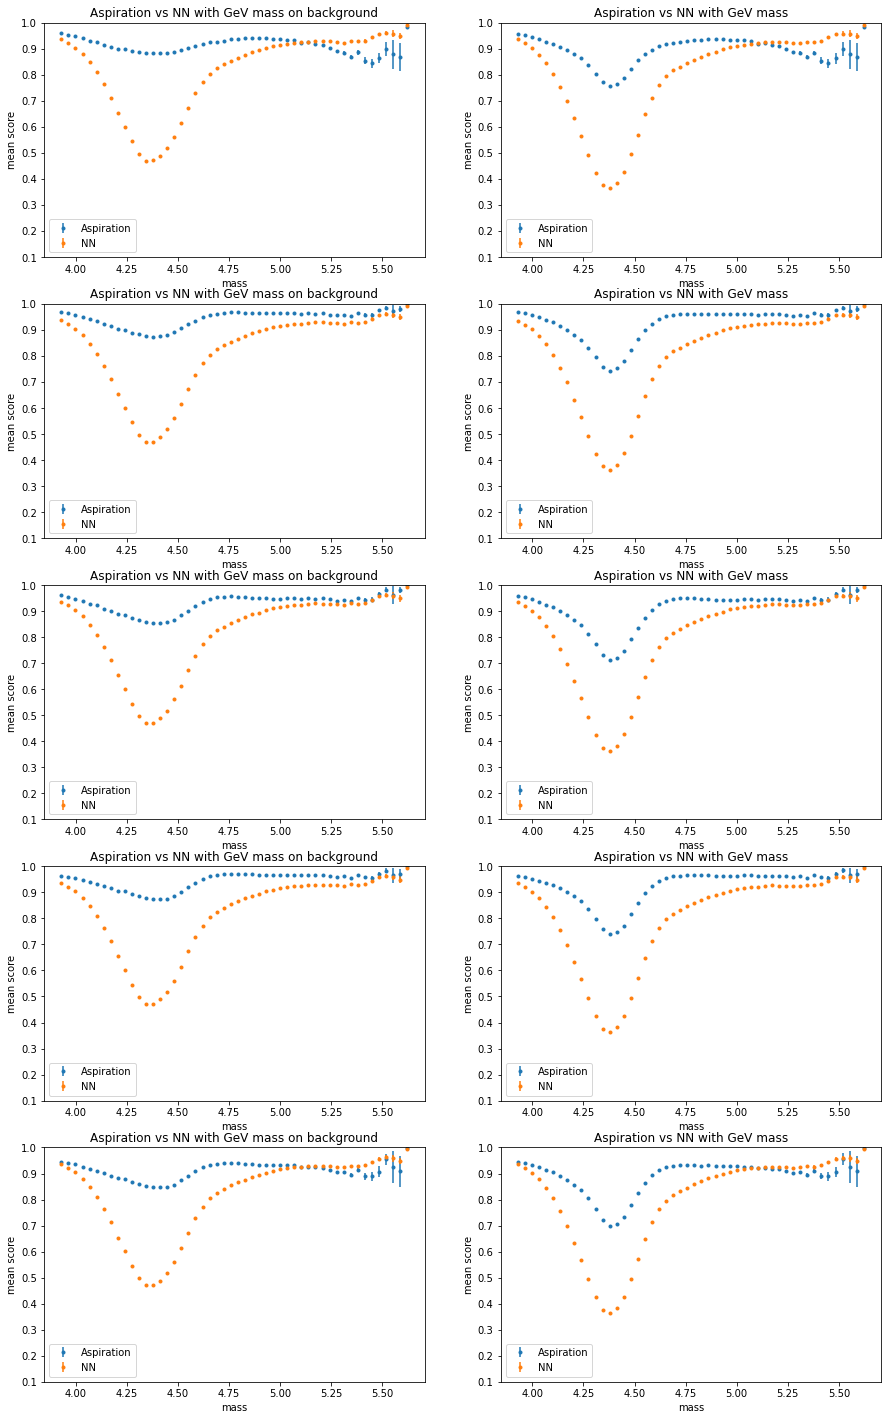

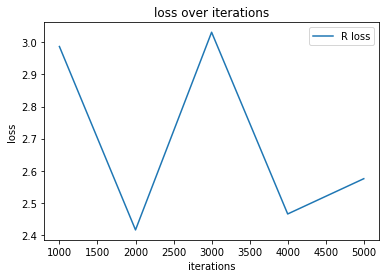

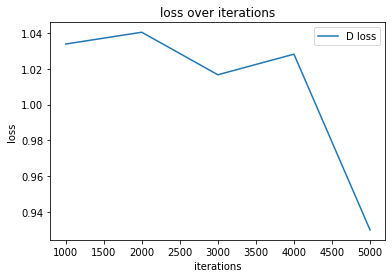

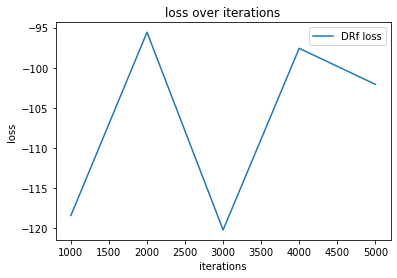

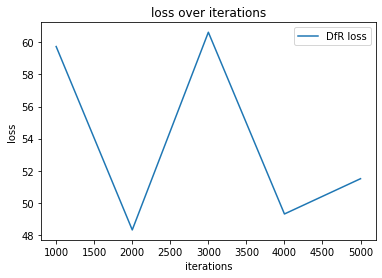

In [ ]:
batch_size = 256
training_iterations = 5001 #20001 #51 #20001
interval = 1000
tr = 50  #originally 10 #increase 10x more
signal_train = X_train[y_train==0]
signal_mass_train = mass_train[y_train==0]


r_results = np.zeros(training_iterations//interval)
d_results = np.zeros(training_iterations//interval)
drf_results = np.zeros(training_iterations//interval)
dfr_results = np.zeros(training_iterations//interval)

iterations_results = np.zeros(training_iterations//interval)

nrows = training_iterations//interval
fig, axes = plt.subplots(nrows, 2, figsize=(15,25))

j = 0

for i in range(1,training_iterations+1):
    #l = DRf.evaluate(X_test, [y_test, mass_test], sample_weight=[weights_test,weights_test], verbose=0)  
    #l = DRf.evaluate(X_train, [y_train, mass_train], sample_weight=[weights_train,weights_train], verbose=0)  
    #losses["L_f - L_r"].append(l[0][None][0])
    #losses["L_f"].append(l[1][None][0]) # why none, 0? just do l[1]??
    #losses["L_r"].append(-l[2][None][0]) # the - cancels the - in loss -lam
    #print(losses["L_f"][-1], losses["L_r"][-1] / lam, losses["L_r"][-1])
    #
    #if i % 5 == 0:
    #    plot_losses(i, losses)

    # Fit D
    make_trainable(R, False)
    make_trainable(D, True)
    indices = np.random.permutation(len(X_train))[:batch_size]
    #print("DRf")
    #use iloc
    ##DRf.train_on_batch(X_train[indices], [y_train[indices], mass_train[indices]], sample_weight=[weights_train[indices], weights_train[indices]])
    # flat for signal only
    #DRf.train_on_batch([X_train[indices], mass_train[indices]], [y_train[indices], np.zeros(len(indices))], sample_weight=[weights_train[indices], weights_train[indices] * y_train[indices]])
    #flat on both

    #sample_weight1 = [class_weight for every point]
    

    #sample_weight2 = [0s if signal, sampleweight1 if background] test first with equal to sampleweight1
    #sample_weight2 = np.copy(sample_weight1)

    DRf.train_on_batch([X_train[indices], mass_train[indices]], [y_train[indices], np.zeros(len(indices))], sample_weight = [sample_weight1[indices], sample_weight2[indices]])
    #@TODO: Make explicite masking with weights, y_train mught become multiclass/multilabel later
    
    # Fit R
    make_trainable(R, True)
    make_trainable(D, False)
    #print("DfR")
    #masking background events
    indices_R = np.random.permutation(len(X_train))[:batch_size*tr]
    ##indices_R = np.random.permutation(len(signal_train))[:batch_size*tr]
    d_scores = D.predict(X_train[indices_R])
    ##d_scores = D.predict(signal_train[indices_R])
    #uniform_dist = np.random.uniform(0,1,len(d_scores))
    rand_Indices = np.random.permutation(len(X_train))[:batch_size*tr]
    ##rand_Indices = np.random.permutation(len(signal_train))[:batch_size*tr]
    randSample_mass = mass_train[rand_Indices]
    ##randSample_mass = signal_mass_train[rand_Indices]
    doubleScores = np.concatenate([d_scores, d_scores], axis=0)

    doubleWeights = np.concatenate([sample_weight1[indices_R], sample_weight2[indices_R]], axis=0)

    doubleMasses = np.concatenate([mass_train[indices_R], randSample_mass], axis=0)
    ##doubleMasses = np.concatenate([signal_mass_train[indices_R], randSample_mass], axis=0)
    realFake = [0]*len(d_scores) + [1]*len(d_scores)
    
    realFake = np.array(realFake)

    if (useSavedModel):
      pass
      #DfR.load_weights('/content/gdrive/MyDrive/DecorrelationModels/Aspiration1')
    else:
      DfR.fit([doubleScores, doubleMasses], realFake, batch_size=batch_size, epochs=1, verbose=0, sample_weight=doubleWeights, shuffle=True)


    if i % interval == 0:
      

      d_results[j] = D.evaluate(X_test, y_test, sample_weight = sample_weight_test, batch_size = 4000)


      #feeding in aspired vs real in R
      r_scores = D.predict(X_test)
      r_first_input = np.concatenate([r_scores, r_scores], axis=0)
      mass_test_rndm = np.copy(mass_test)
      np.random.shuffle(mass_test_rndm)
      r_second_input = np.concatenate([mass_test, mass_test_rndm], axis=0)
      r_labels = np.array([0]*len(r_scores) + [1]*len(r_scores))
      r_results[j] = R.evaluate([r_first_input, r_second_input], r_labels, sample_weight = double_mask_weights, batch_size = 4000)

      print(roc_auc_score(y_true=r_labels, y_score=R.predict([r_first_input, r_second_input]), sample_weight= double_mask_weights))

      #try training R after many runs of D from aspiration

      dfr_results[j] = DfR.evaluate([r_first_input, r_second_input], r_labels, sample_weight = double_mask_weights, batch_size = 4000)

      drf_results[j] = (DRf.evaluate([X_test, mass_test], [y_test, np.zeros(len(y_test))], sample_weight = [sample_weight_test, mask_sample_weight_test], batch_size = 4000))[0]


      iterations_results[j] = i

      #periodic plots
      # only background, trained on signal and background
      y_adv_pred_train = D.predict(X_train)
      y_adv_pred = D.predict(X_test)

      # only background, trained on signal and background
      axes[j,0].set_title("Aspiration vs NN with GeV mass on background")
      axplot_profile(getGevMass(mass_test[y_test==1]), y_adv_pred.reshape(-1)[y_test==1], axes, j, 0, errorBars=True, label="Aspiration")
      axplot_profile(getGevMass(mass_test[y_test==1]), y_pred.reshape(-1)[y_test==1], axes, j, 0, errorBars=True, label="NN")
      #plt.savefig("/content/gdrive/MyDrive/DecorrelationModels/plot2_1")

      # trained on signal and background
      axes[j,1].set_title("Aspiration vs NN with GeV mass")
      axplot_profile(getGevMass(mass_test), y_adv_pred.reshape(-1), axes, j, 1, errorBars=True, label="Aspiration")
      axplot_profile(getGevMass(mass_test), y_pred.reshape(-1), axes, j, 1, errorBars=True, label="NN")
      #plt.savefig("/content/gdrive/MyDrive/DecorrelationModels/plot3_1")

      j = j+1



    '''
    if i % (5*interval) == 0:
      plt.plot(iterations_results[:j*interval], r_results[:j*interval], label = 'R loss')
      plt.title('loss over iterations')
      plt.ylabel('loss')
      plt.xlabel('iterations')
      plt.legend()
      plt.show()

      plt.plot(iterations_results[:j*interval], d_results[:j*interval], label = 'D loss')
      plt.title('loss over iterations')
      plt.ylabel('loss')
      plt.xlabel('iterations')
      plt.legend()
      plt.show()

      plt.plot(iterations_results[:j*interval], drf_results[:j*interval], label = 'DRf loss')
      plt.title('loss over iterations')
      plt.ylabel('loss')
      plt.xlabel('iterations')
      plt.legend()
      plt.show()

      plt.plot(iterations_results[:j*interval], dfr_results[:j*interval], label = 'DfR loss')
      plt.title('loss over iterations')
      plt.ylabel('loss')
      plt.xlabel('iterations')
      plt.legend()
      plt.show()
    '''


    ##DfR.fit(X_train, mass_train, batch_size=batch_size, sample_weight=weights_train, nb_epoch=1, verbose=1)
    #DfR.fit(X_train, mass_train, batch_size=batch_size, nb_epoch=1, verbose=1)
    #DfR.fit(X_train, mass_train, nb_epoch=1, verbose=1)
    #DfR.fit(X_train, mass_train, sample_weight=weights_train, nb_epoch=1, verbose=1)
    #@TODO: try grad reversal layer

# summarize history for loss
plt.show()

plt.plot(iterations_results, r_results, label = 'R loss')
plt.title('loss over iterations')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()
plt.show()

plt.plot(iterations_results, d_results, label = 'D loss')
plt.title('loss over iterations')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()
plt.show()

plt.plot(iterations_results, drf_results, label = 'DRf loss')
plt.title('loss over iterations')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()
plt.show()

plt.plot(iterations_results, dfr_results, label = 'DfR loss')
plt.title('loss over iterations')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()
plt.show()



In [ ]:
double_mask_weights = np.concatenate([mask_sample_weight_train, mask_sample_weight_train], axis=0)

r_scores = D.predict(X_train)
r_first_input = np.concatenate([r_scores, r_scores], axis=0)
mass_train_rndm = np.copy(mass_train)
np.random.shuffle(mass_train_rndm)
r_second_input = np.concatenate([mass_train, mass_train_rndm], axis=0)
r_labels = np.array([0]*len(r_scores) + [1]*len(r_scores))

In [ ]:
Cin1 = Input(shape=(1,))
Cin2 = Input(shape=(1,))
Cin = concatenate([Cin1, Cin2 ], axis=-1)
with K.name_scope('Advers'):
    Cx = Dense(32, activation="relu")(Cin)
    Cx = Dense(32, activation="relu")(Cx)
    Cx = Dense(32, activation="relu")(Cx)
    Cx = Dense(1, activation="sigmoid")(Cx)
    C = Model(inputs=[Cin1, Cin2], outputs=[Cx])

C.compile(loss= [make_loss_R(c=1.0)], optimizer=opt_D)

In [ ]:
C.fit([r_first_input, r_second_input], r_labels, sample_weight = double_mask_weights, epochs =20)
x_plot_train = r_scores
plot_results = C.predict([r_scores, mass_train_rndm])
y_plot_train_real = plot_results[:len(plot_results)//2]
y_plot_train_aspired = plot_results[len(plot_results)//2:]

Epoch 1/20
22500/22500 [==============================] - 37s 2ms/step - loss: 0.3156
Epoch 2/20
22500/22500 [==============================] - 36s 2ms/step - loss: 0.3136
Epoch 3/20
22500/22500 [==============================] - 36s 2ms/step - loss: 0.3134
Epoch 4/20
22500/22500 [==============================] - 36s 2ms/step - loss: 0.3133
Epoch 5/20
22500/22500 [==============================] - 37s 2ms/step - loss: 0.3132
Epoch 6/20
22500/22500 [==============================] - 37s 2ms/step - loss: 0.3131
Epoch 7/20
22500/22500 [==============================] - 36s 2ms/step - loss: 0.3130
Epoch 8/20
22500/22500 [==============================] - 36s 2ms/step - loss: 0.3130
Epoch 9/20
22500/22500 [==============================] - 36s 2ms/step - loss: 0.3130
Epoch 10/20
22500/22500 [==============================] - 36s 2ms/step - loss: 0.3129
Epoch 11/20
22500/22500 [==============================] - 36s 2ms/step - loss: 0.3129
Epoch 12/20
22500/22500 [===========================

In [ ]:
print(roc_auc_score(y_true=r_labels, y_score=C.predict([r_first_input, r_second_input]), sample_weight= double_mask_weights))

0.7048654744628098


In [ ]:
double_mask_weights = np.concatenate([mask_sample_weight_test, mask_sample_weight_test], axis=0)

r_scores = D.predict(X_test)
r_first_input = np.concatenate([r_scores, r_scores], axis=0)
mass_test_rndm = np.copy(mass_test)
np.random.shuffle(mass_test_rndm)
r_second_input = np.concatenate([mass_test, mass_test_rndm], axis=0)
r_labels = np.array([0]*len(r_scores) + [1]*len(r_scores))

print(roc_auc_score(y_true=r_labels, y_score=C.predict([r_first_input, r_second_input]), sample_weight= double_mask_weights))

0.4950786573376451


In [ ]:
x_plot_test = r_scores
plot_results = C.predict([r_scores, mass_test_rndm])
y_plot_test_real = plot_results[:len(plot_results)//2]
y_plot_test_aspired = plot_results[len(plot_results)//2:]

In [ ]:
len(y_plot_train_real)

180000

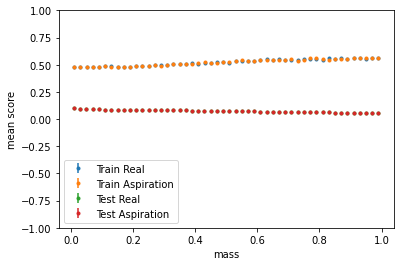

In [ ]:
plot_profile(x_plot_train[:len(y_plot_train_real)].T[0], y_plot_train_real.T[0], ylim = (-1,1), errorBars=True, label="Train Real")
plot_profile(x_plot_train[len(y_plot_train_aspired):].T[0], y_plot_train_aspired.T[0], ylim = (-1,1), errorBars=True, label="Train Aspiration")
plot_profile(x_plot_test[:len(y_plot_test_real)].T[0], y_plot_test_real.T[0], ylim = (-1,1), errorBars=True, label="Test Real")
plot_profile(x_plot_test[len(y_plot_test_aspired):].T[0], y_plot_test_aspired.T[0], ylim = (-1,1), errorBars=True, label="Test Aspiration")
plt.show()

In [ ]:
y_adv_pred_train = D.predict(X_train)
y_adv_pred = D.predict(X_test)

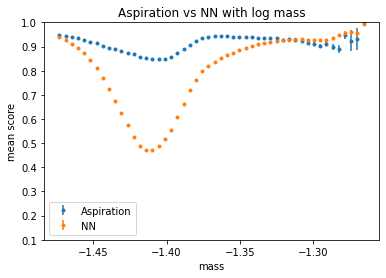

In [ ]:
# only background, trained on signal and background
plt.title("Aspiration vs NN with log mass")
plot_profile(mass_test[y_test==1], y_adv_pred.reshape(-1)[y_test==1], label="Aspiration")
plot_profile(mass_test[y_test==1], y_pred.reshape(-1)[y_test==1], label="NN")
plt.savefig("/content/gdrive/MyDrive/DecorrelationModels/plot1_1")

In [ ]:
mass_test[y_test==1]

array([-1.34662519, -1.45418287, -1.36382892, ..., -1.29680237,
       -1.35571263, -1.34052431])

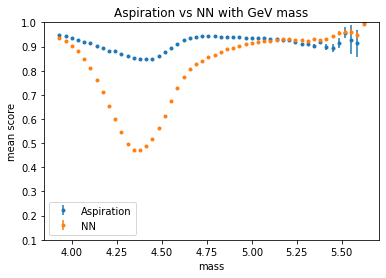

In [ ]:
# both, trained on signal and background
plt.title("Aspiration vs NN with GeV mass")
plot_profile(getGevMass(mass_test[y_test==1]), y_adv_pred.reshape(-1)[y_test==1], errorBars=True, label="Aspiration")
plot_profile(getGevMass(mass_test[y_test==1]), y_pred.reshape(-1)[y_test==1], errorBars=True, label="NN")
plt.savefig("/content/gdrive/MyDrive/DecorrelationModels/plot2_1")
plt.show()

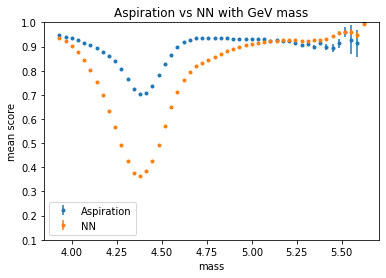

In [ ]:
# only background, trained on signal and background
plt.title("Aspiration vs NN with GeV mass")
plot_profile(getGevMass(mass_test), y_adv_pred.reshape(-1), errorBars=True, label="Aspiration")
plot_profile(getGevMass(mass_test), y_pred.reshape(-1), errorBars=True, label="NN")
plt.savefig("/content/gdrive/MyDrive/DecorrelationModels/plot3_1")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


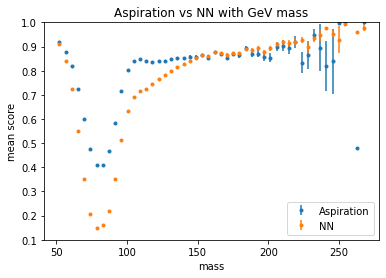

In [ ]:
# only background, trained on signal and background
plt.title("Aspiration vs NN with GeV mass")
plot_profile(getGevMass(mass_train), y_adv_pred_train.reshape(-1), label="Aspiration")
plot_profile(getGevMass(mass_train), y_pred_train.reshape(-1), label="NN")
plt.savefig("/content/gdrive/MyDrive/DecorrelationModels/plot4_1")

In [ ]:
# only signal, trained on signal and background
#plot_profile(getGevMass(mass_test), y_pred.reshape(-1), errorBars=True, label="NN")

In [ ]:
from sklearn.metrics import roc_auc_score
#y_pred = D.predict(X_test)
#y_pred = y_pred.ravel()
y_adv_pred = y_adv_pred.ravel()

##auc_test_nn = roc_auc_score(y_true=y_test, y_score=y_adv_pred, sample_weight=weights_test)
##print auc_test_nn
#roc_auc_score(y_true=y_test, y_score=y_adv_pred)

from sklearn.metrics import roc_curve
lw = 2
fpr_nn,tpr_nn,_ = roc_curve(y_true=y_test, y_score=y_pred, sample_weight=weights_test)
plt.plot(fpr_nn, tpr_nn, color='darkorange',lw=lw, label='NN (AUC = {})'.format(np.round(auc_test_nn,decimals=2)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#int_pred_test_sig = [weights_train[(y_train ==1) & (y_adv_pred_train > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
#int_pred_test_bkg = [weights_train[(y_train ==0) & (y_adv_pred_train > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

int_pred_test_sig = [weights_test[(y_test ==0) & (y_adv_pred > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg = [weights_test[(y_test ==1) & (y_adv_pred > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

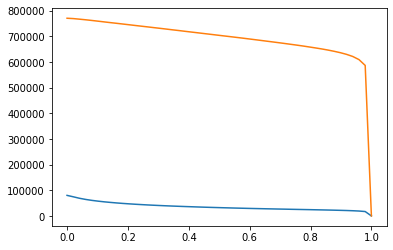

In [ ]:
plt.plot(np.linspace(0,1,num=50),int_pred_test_sig)
plt.plot(np.linspace(0,1,num=50),int_pred_test_bkg)

In [ ]:
from util_func import amsasimov
vamsasimov = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig,int_pred_test_bkg)]
significance = max(vamsasimov)
threshold = np.linspace(0,1,num=50)[ np.array(vamsasimov).argmax() ]

In [ ]:
significance, threshold

(89.65444150891518, 0.0)

In [ ]:
# classifier trained only on signal adversary
significance, threshold # on only 201 iterations (1.7920479509299039, 0.8979591836734693)

(89.65444150891518, 0.0)

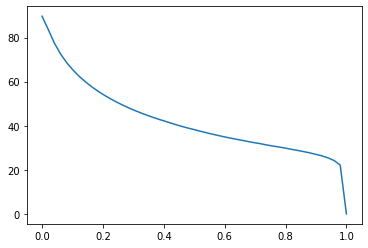

In [ ]:
plt.plot(np.linspace(0,1,num=50),vamsasimov)

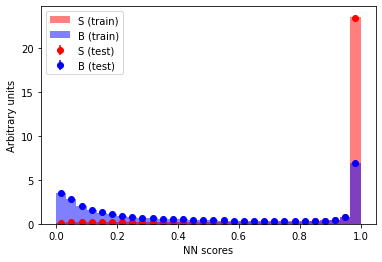

In [ ]:
from util_func import compare_train_test
compare_train_test(y_adv_pred_train, y_train, y_adv_pred, y_test)

In [ ]:
auc_test_AonTest = roc_auc_score(y_true=y_test, y_score=y_adv_pred,)
auc_test_AonTrain = roc_auc_score(y_true=y_train, y_score=y_adv_pred_train,)
auc_test_NNonTest = roc_auc_score(y_true=y_test, y_score=y_pred,)
auc_test_NNonTrain = roc_auc_score(y_true=y_train, y_score=y_pred_train,)
print(auc_test_AonTest, auc_test_AonTrain, auc_test_NNonTest, auc_test_NNonTrain)

0.8592587418344155 0.8590186772727273 0.900504108887987 0.9011410768545455


# Threshold per bin plot

0.9027673755858593 0.9
0.899912181339171 0.9
0.901108467297313 0.9
0.9022186006889144 0.9
0.8911960132890365 0.9
0.795298994323936 0.8
0.8013219466045572 0.8
0.7924235389704603 0.8
0.8163172710100374 0.8
0.7936046511627907 0.8
0.9007748651640406 0.9
0.902211587820782 0.9
0.900707058982841 0.9
0.9000425941701544 0.9
0.8996400885935769 0.9
0.8048423184719377 0.8
0.7980807168039098 0.8
0.7845598050026116 0.8
0.7942979369606282 0.8
0.7945736434108527 0.8


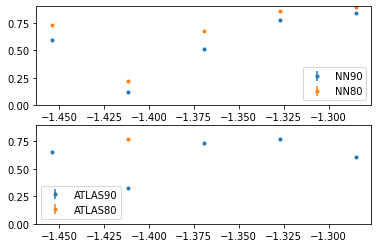

In [ ]:
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    print (array[idx], value)
    return array[idx], idx

def findThreshold(values, passFraction):
    total = len(values)
    if total == 0:
        return 0 # np.nan
    assert not ( (values > 1).any() or (values < 0).any())
    integral = np.array([(values > th_cut).sum()/total for th_cut in np.linspace(0,1,num=50)])
    th_, idx = find_nearest(integral, passFraction)
    threshold = np.linspace(0,1,num=50)[idx]
    return threshold
def findThreshold90(values):
    return findThreshold(values, 0.9)
def findThreshold80(values):
    return findThreshold(values, 0.8)

def binnedFractionLine(mass, y_pred, statistic, bins=5):
    frac_result = scipy.stats.binned_statistic(mass, y_pred, bins=5, statistic=statistic)
    count_result = scipy.stats.binned_statistic(mass, y_pred, bins=5, statistic="count")
    thresholdsFrac = frac_result.statistic
    countPerBin = count_result.statistic
    bin_edges = frac_result.bin_edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    return bin_centers, thresholdsFrac, countPerBin
plt.subplot(2,1,1)
bin_centers, thresholds90, countPerBin = binnedFractionLine(mass_test[y_test==1], y_pred[y_test==1], statistic=findThreshold90 )
plt.errorbar(x=bin_centers, y=thresholds90, yerr=np.sqrt(thresholds90)/countPerBin, linestyle='none', marker='.',label="NN90")

bin_centers, thresholds80, countPerBin = binnedFractionLine(mass_test[y_test==1], y_pred[y_test==1], statistic=findThreshold80 )
plt.errorbar(x=bin_centers, y=thresholds80, yerr=np.sqrt(thresholds80)/countPerBin, linestyle='none', marker='.',label="NN80")

plt.ylim(0.,0.9)
plt.legend()


plt.subplot(2,1,2)
bin_centers, thresholds90, countPerBin = binnedFractionLine(mass_test[y_test==1], y_adv_pred.reshape(-1)[y_test==1], statistic=findThreshold90 )
plt.errorbar(x=bin_centers, y=thresholds90, yerr=np.sqrt(thresholds90)/countPerBin, linestyle='none', marker='.',label="ATLAS90")

bin_centers, thresholds80, countPerBin = binnedFractionLine(mass_test[y_test==1], y_adv_pred.reshape(-1)[y_test==1], statistic=findThreshold80 )
plt.errorbar(x=bin_centers, y=thresholds80, yerr=np.sqrt(thresholds80)/countPerBin, linestyle='none', marker='.',label="ATLAS80")

plt.ylim(0.,0.9)
plt.legend()

#plt.savefig("Plots/Aspiration/threshold_NN_vs_ATLAS.pdf")

In [ ]:
def findT( a,  b):
    return a*b

func = lambda values: findT(values, 0.9)

In [ ]:
def eval_f(x):
    return x(1)

eval_f(lambda values: findT(values, 0.9)), eval_f(lambda values: findT(values, 3))

(0.9, 3)